**Chapter 15 – Processing Sequences Using RNNs and CNNs**

_This notebook contains all the sample code in chapter 15._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Basic RNNs

### Generate the Dataset

In [6]:
windows = 50
horizon = 1 

In [7]:
def generate_time_series(batch_size, windows):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, windows)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 9 + 9))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 19 + 19)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, windows) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [10]:
np.random.seed(42)

series = generate_time_series(3000, windows + horizon)

X_train, y_train = series[:1000, :windows], series[:1000, -horizon:, 0]
X_valid, y_valid = series[1000:2000, :windows], series[1000:2000, -horizon:, 0]
X_test, y_test = series[2000:, :windows], series[2000:, -horizon:, 0]

In [11]:
X_train.shape, y_train.shape

((1000, 50, 1), (1000, 1))

In [13]:
def plot_series(series, windows, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(windows, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(windows, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, windows + 1, -1, 1])

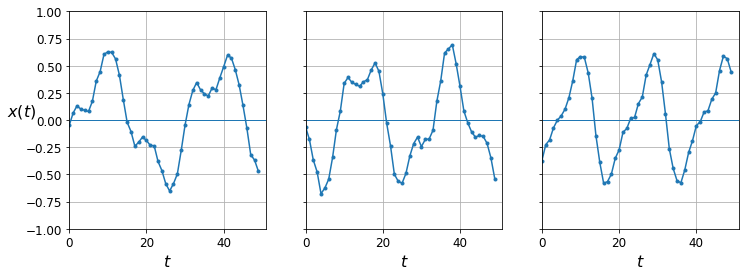

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    #plot_series(X_valid[col, :, 0], y_valid[col, 0], y_label=("$x(t)$" if col==0 else None))
    plot_series(X_valid[col, :, 0], windows, y_label=("$x(t)$" if col==0 else None))

plt.show()

In [36]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

### Computing Some Baselines

Naive predictions (just predict the last observed value):

In [17]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.01627411

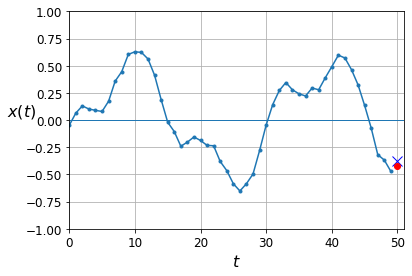

In [35]:
plot_series(X_valid[0, :, 0],windows,y_valid[0, 0], y_pred[0, 0])
plt.show()

Linear predictions:

In [37]:
np.random.seed(42)
tf.random.set_seed(42)

model_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[windows, 1]),
    keras.layers.Dense(horizon)
])


model_1.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history_1 = model_1.fit(X_train, Y_train, epochs=30, validation_data=(X_valid, Y_valid))

C:\Users\admin\anaconda3\envs\tf\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
32/32 [==============================] - 0s 8ms/step - loss: 0.0901 - last_time_step_mse: 0.0884 - val_loss: 0.0363 - val_last_time_step_mse: 0.0361
Epoch 2/30
32/32 [==============================] - 0s 5ms/step - loss: 0.0252 - last_time_step_mse: 0.0250 - val_loss: 0.0167 - val_last_time_step_mse: 0.0166
Epoch 3/30
32/32 [==============================] - 0s 5ms/step - loss: 0.0147 - last_time_step_mse: 0.0146 - val_loss: 0.0130 - val_last_time_step_mse: 0.0129
Epoch 4/30
32/32 [==============================] - 0s 5ms/step - loss: 0.0122 - last_time_step_mse: 0.0122 - val_loss: 0.0107 - val_last_time_step_mse: 0.0106
Epoch 5/30
32/32 [==============================] - 0s 5ms/step - loss: 0.0103 - last_time_step_mse: 0.0101 - val_loss: 0.0101 - val_last_time_step_mse: 0.0101
Epoch 6/30
32/32 [==============================] - 0s 5ms/step - loss: 0.0087 - last_time_step_mse: 0.0088 - val_loss: 0.0085 - val_last_time_step_mse: 0.0084
Epoch 7/30
32/32 [======================

In [38]:
model1.evaluate(X_valid, y_valid)

32/32 [==============================] - 0s 2ms/step - loss: 0.0128


0.012767571024596691

In [48]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.gca().yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 30, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

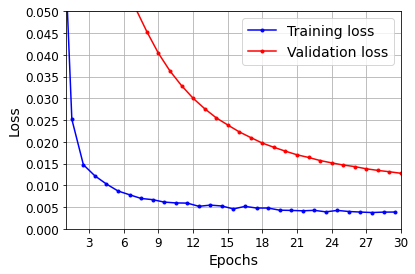

In [49]:
plot_learning_curves(history_1.history["loss"], history1.history["val_loss"])
plt.show()

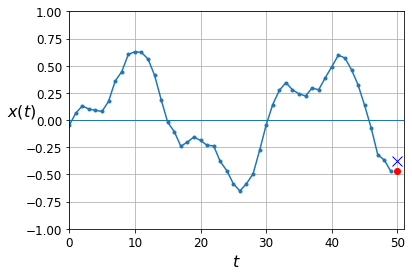

In [41]:
y_pred = model_1.predict(X_valid)
plot_series(X_valid[0, :, 0],windows,y_valid[0, 0], y_pred[0, 0])
plt.show()

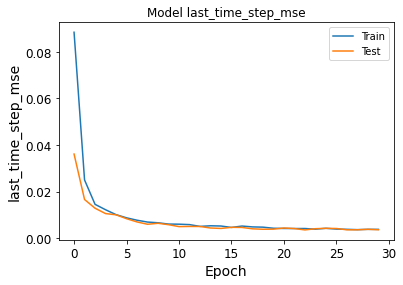

In [42]:
plt.plot(history_1.history['last_time_step_mse'])
plt.plot(history_1.history['val_last_time_step_mse'])
plt.title('Model last_time_step_mse')
plt.xlabel('Epoch')
plt.ylabel('last_time_step_mse')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

### Using a Simple RNN

In [52]:
np.random.seed(42)
tf.random.set_seed(42)

model_2 = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

model_2.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history_2 = model_2.fit(X_train, Y_train, epochs=30, validation_data=(X_valid, Y_valid))

Epoch 1/30
32/32 [==============================] - 4s 95ms/step - loss: 0.1649 - last_time_step_mse: 0.1634 - val_loss: 0.0788 - val_last_time_step_mse: 0.0796
Epoch 2/30
32/32 [==============================] - 3s 92ms/step - loss: 0.0670 - last_time_step_mse: 0.0671 - val_loss: 0.0525 - val_last_time_step_mse: 0.0530
Epoch 3/30
32/32 [==============================] - 3s 92ms/step - loss: 0.0479 - last_time_step_mse: 0.0479 - val_loss: 0.0413 - val_last_time_step_mse: 0.0416
Epoch 4/30
32/32 [==============================] - 3s 94ms/step - loss: 0.0387 - last_time_step_mse: 0.0387 - val_loss: 0.0339 - val_last_time_step_mse: 0.0340
Epoch 5/30
32/32 [==============================] - 3s 90ms/step - loss: 0.0331 - last_time_step_mse: 0.0329 - val_loss: 0.0293 - val_last_time_step_mse: 0.0294
Epoch 6/30
32/32 [==============================] - 3s 90ms/step - loss: 0.0287 - last_time_step_mse: 0.0284 - val_loss: 0.0259 - val_last_time_step_mse: 0.0260
Epoch 7/30
32/32 [================

In [53]:
model_2.evaluate(X_valid, y_valid)

32/32 [==============================] - 0s 12ms/step - loss: 0.0098 - last_time_step_mse: 0.0098


[0.009829442948102951, 0.00982597004622221]

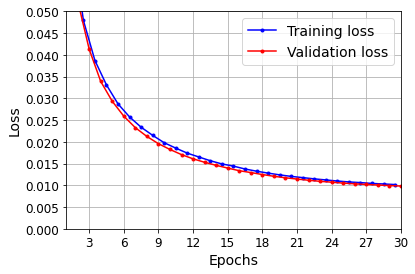

In [54]:
plot_learning_curves(history_2.history["loss"], history_2.history["val_loss"])
plt.show()

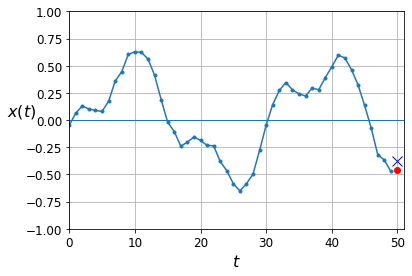

In [55]:
y_pred = model2.predict(X_valid)
plot_series(X_valid[0, :, 0],windows,y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs

In [51]:
np.random.seed(42)
tf.random.set_seed(42)

model_3 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(horizon)
])

model_3.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history_3 = model_3.fit(X_train, Y_train, epochs=30, validation_data=(X_valid, Y_valid))

C:\Users\admin\anaconda3\envs\tf\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
32/32 [==============================] - 10s 285ms/step - loss: 0.2052 - last_time_step_mse: 0.2017 - val_loss: 0.0429 - val_last_time_step_mse: 0.0425
Epoch 2/30
32/32 [==============================] - 9s 271ms/step - loss: 0.0214 - last_time_step_mse: 0.0210 - val_loss: 0.0124 - val_last_time_step_mse: 0.0123
Epoch 3/30
32/32 [==============================] - 9s 268ms/step - loss: 0.0068 - last_time_step_mse: 0.0068 - val_loss: 0.0045 - val_last_time_step_mse: 0.0045
Epoch 4/30
32/32 [==============================] - 9s 273ms/step - loss: 0.0049 - last_time_step_mse: 0.0049 - val_loss: 0.0045 - val_last_time_step_mse: 0.0045
Epoch 5/30
32/32 [==============================] - 9s 272ms/step - loss: 0.0044 - last_time_step_mse: 0.0044 - val_loss: 0.0043 - val_last_time_step_mse: 0.0043
Epoch 6/30
32/32 [==============================] - 9s 271ms/step - loss: 0.0040 - last_time_step_mse: 0.0040 - val_loss: 0.0039 - val_last_time_step_mse: 0.0039
Epoch 7/30
32/32 [=========

In [56]:
model_3.evaluate(X_valid, y_valid)

32/32 [==============================] - 0s 2ms/step - loss: 0.0179


0.017851222306489944

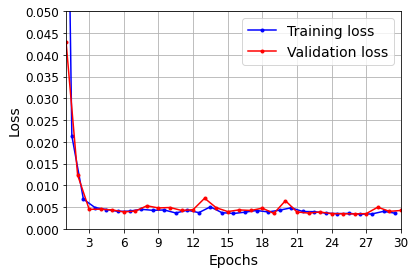

In [57]:
plot_learning_curves(history_3.history["loss"], history_3.history["val_loss"])
plt.show()

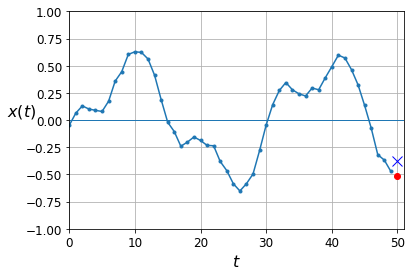

In [58]:
y_pred = model_3.predict(X_valid)
plot_series(X_valid[0, :, 0], windows,y_valid[0, 0], y_pred[0, 0])
plt.show()

Make the second `SimpleRNN` layer return only the last output:

In [60]:
np.random.seed(42)
tf.random.set_seed(42)

model_4 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(horizon)
])

model_4.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history_4 = model_4.fit(X_train, Y_train, epochs=30, validation_data=(X_valid, Y_valid))

C:\Users\admin\anaconda3\envs\tf\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
32/32 [==============================] - 7s 194ms/step - loss: 0.0578 - last_time_step_mse: 0.0566 - val_loss: 0.0056 - val_last_time_step_mse: 0.0056
Epoch 2/30
32/32 [==============================] - 6s 187ms/step - loss: 0.0044 - last_time_step_mse: 0.0045 - val_loss: 0.0037 - val_last_time_step_mse: 0.0037
Epoch 3/30
32/32 [==============================] - 6s 189ms/step - loss: 0.0037 - last_time_step_mse: 0.0037 - val_loss: 0.0038 - val_last_time_step_mse: 0.0038
Epoch 4/30
32/32 [==============================] - 6s 187ms/step - loss: 0.0035 - last_time_step_mse: 0.0034 - val_loss: 0.0035 - val_last_time_step_mse: 0.0035
Epoch 5/30
32/32 [==============================] - 6s 188ms/step - loss: 0.0032 - last_time_step_mse: 0.0032 - val_loss: 0.0034 - val_last_time_step_mse: 0.0033
Epoch 6/30
32/32 [==============================] - 6s 199ms/step - loss: 0.0033 - last_time_step_mse: 0.0033 - val_loss: 0.0035 - val_last_time_step_mse: 0.0035
Epoch 7/30
32/32 [==========

In [61]:
model_4.evaluate(X_valid, y_valid)

32/32 [==============================] - 1s 16ms/step - loss: 0.0035 - last_time_step_mse: 0.0035


[0.003520538564771414, 0.003501287428662181]

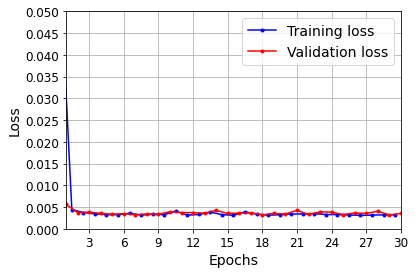

In [62]:
plot_learning_curves(history_4.history["loss"], history_4.history["val_loss"])
plt.show()

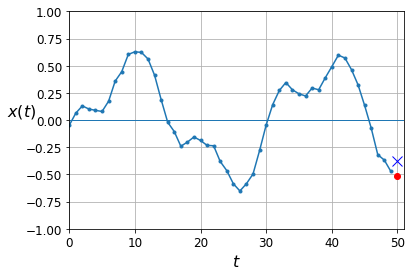

In [63]:
y_pred = model_4.predict(X_valid)
plot_series(X_valid[0, :, 0], windows, y_valid[0, 0], y_pred[0, 0])
plt.show()

# Single step models

In [66]:
windows = 7
horizon = 1 

In [68]:
np.random.seed(42)

series = generate_time_series(3000, windows + horizon)

train_df = series[:1000, :windows]
val_df = series[1000:2000, :windows]
test_df = series[2000:, :windows]

In [71]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
    #self.column_indices = {name: i for i, name in  enumerate(train_df.columns)}
    self.column_indices = 1

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [73]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['sinefunction'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['sinefunction']

In [78]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    #if self.label_columns is not None: 
    #    labels = tf.stack( [labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
     
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    
    return inputs, labels

WindowGenerator.split_window = split_window

In [79]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

In [80]:
example_inputs, example_labels = w2.split_window(example_window)

ValueError: Tensor's shape (3, 6, 7, 1) is not compatible with supplied shape [None, 6, None]

In [81]:
print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 7, 1)


NameError: name 'example_inputs' is not defined